# Audio data preparation from zero to PyTorch's DataLoader

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from lhotse import WavAugmenter, CutSet, Fbank, FbankConfig
from lhotse.recipes.librispeech import download_and_untar, prepare_librispeech

## Getting mini LibriSpeech and creating manifests

In [2]:
download_and_untar('data')

In [3]:
manifests = prepare_librispeech('data/LibriSpeech')
train = manifests['train-clean-5']
dev = manifests['dev-clean-2']

## Creating the Cuts

### First, we create the "starting point" cut sets - i.e. cuts that actually span full recordings.

In [4]:
train_cuts = CutSet.from_manifests(recordings=train['recordings'], supervisions=train['supervisions'])
dev_cuts = CutSet.from_manifests(recordings=dev['recordings'], supervisions=dev['supervisions'])

### We can see the cut durations are far from equal - we'd like to use 5 second long cuts for this experiment.

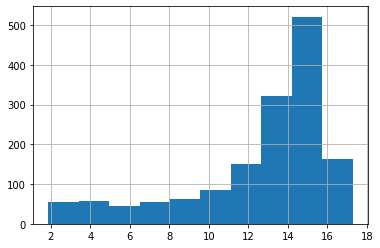

In [5]:
pd.Series(c.duration for c in train_cuts).hist()

### We can cut the longer recordings into 5 second cuts by traversing them in windows; the left-over portion of the recording might still be shorter, so we will pad it with silence to 5 seconds.

In [6]:
train_cuts_filt = train_cuts.cut_into_windows(5).pad(5)
assert all(cut.duration == 5 for cut in train_cuts_filt)
len(train_cuts), len(train_cuts_filt)

(1519, 4571)

### Let's create a simple dataset for our very specific task - classification whether an audio clip has been reverberated.

In [7]:
import torch
import random

class ReverbDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, cuts):
        self.cuts = cuts
        self.cut_ids = list(cuts.ids)
        self.extractor = Fbank(FbankConfig(num_mel_bins=80))
        self.augmenter = WavAugmenter.create_predefined('reverb', cuts[0].sampling_rate)

    def __getitem__(self, idx):
        cut = self.cuts[self.cut_ids[idx]]
        augment = random.choice([0, 1])
        feats = cut.compute_features(self.extractor, self.augmenter if augment else None)
        return torch.from_numpy(feats), float(augment)
    
    def __len__(self):
        return len(self.cuts)

### Creating the DataLoader is very simple - no collate_fn is needed at all, since we used CutSet's capabilities to bring the data to equal length.

In [8]:
train_dset = ReverbDetectionDataset(train_cuts_filt)
val_dset = ReverbDetectionDataset(dev_cuts)

train_dloader = torch.utils.data.DataLoader(train_dset, batch_size=8, shuffle=True, num_workers=2)
val_dloader = torch.utils.data.DataLoader(val_dset, batch_size=1, num_workers=1)

In [9]:
for feats, targets in train_dloader:
    print('Training DataLoader shapes:')
    print(feats.shape, targets.shape)
    print(targets)
    break
    
for feats, targets in val_dloader:
    print('Dev DataLoader shapes:')
    print(feats.shape, targets.shape)
    break

Training DataLoader shapes:
torch.Size([8, 500, 80]) torch.Size([8])
tensor([1., 1., 0., 1., 0., 1., 0., 0.], dtype=torch.float64)
Dev DataLoader shapes:
torch.Size([1, 1166, 80]) torch.Size([1])
